**Import libraries and load data**

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [4]:
#import csv
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  
# data = pd.read_csv('./heart_failure_dataset.csv')

**Data exploration and pre-processing**

In [3]:
#analyzing 5 rows
data.head(10)

,patient_identifier,age,anemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,current_smoker,room_number,hospital,DEATH_EVENT
0,104,75.0,No,582,NaN,20,Yes,265000.00,1.9,130,male,No,685p,Fairview Range,1
1,105,55.0,No,7861,NaN,38,No,263358.03,1.1,136,Male,No,930F,NaN,1
2,106,65.0,No,146,NaN,20,No,162000.00,1.3,129,Male,Yes,995i,NaN,1
3,107,50.0,Yes,111,NaN,20,No,210000.00,1.9,137,Male,No,562J,NaN,1
4,108,65.0,Yes,160,NaN,20,No,327000.00,2.7,116,Female,No,175D,Brandywine Hospital,1
5,109,90.0,Yes,47,No,40,Yes,204000.00,2.1,132,Male,Yes,902g,NaN,1
6,110,75.0,Yes,246,No,15,No,127000.00,1.2,137,Male,No,111e,NaN,1
7,111,60.0,Yes,315,Yes,60,No,454000.00,1.1,131,Male,Yes,153y,NaN,1
8,112,65.0,No,157,No,65,No,263358.03,1.5,138,female,No,836b,NaN,1
9,113,NaN,Yes,123,No,35,Yes,388000.00,9.4,133,Male,Yes,117r,NaN,1


In [4]:
#finding value counts of patients who are alive or dead
alive_count = data["DEATH_EVENT"].value_counts()[0]
dead_count = data["DEATH_EVENT"].value_counts()[1]
print('alive count: ', alive_count, '\ndead count: ', dead_count)
print('total: ', alive_count + dead_count)

alive count:  203 
dead count:  96
total:  299


*Note:* imbalanced data

In [5]:
data.describe()

,patient_identifier,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,DEATH_EVENT
count,299.000000,284.000000,299.000000,299.000000,269.000000,299.00000,299.000000,299.00000
mean,253.000000,60.684275,581.839465,71.143813,262713.943309,1.39388,136.625418,0.32107
std,86.458082,11.838267,970.287881,576.258182,97783.335019,1.03451,4.412477,0.46767
min,104.000000,40.000000,23.000000,-20.000000,25100.000000,0.50000,113.000000,0.00000
25%,178.500000,50.000000,116.500000,30.000000,211000.000000,0.90000,134.000000,0.00000
50%,253.000000,60.000000,250.000000,38.000000,262000.000000,1.10000,137.000000,0.00000
75%,327.500000,69.000000,582.000000,45.000000,302000.000000,1.40000,140.000000,1.00000
max,402.000000,95.000000,7861.000000,10000.000000,850000.000000,9.40000,148.000000,1.00000


*Analysis:*
- Age has a min of 40 yrs, mean of 60, and max of 95 years old.
- creatinine_phosphokinase has a min of 23.0, mean of 250.0, and max of 7861.0 (possible outlier?)
- ejection fraction has a min of -20.0 (outlier?), mean of 38.0 and max of 10000 (possible outlier?)
- serum creatinine has a min of 0.50, mean of 1.10, and max of 9.40.
- serum sodium has a min of 113.0, mean of 137.0, and 148.0.

It seems as though the features for age, creatinine phosphokinase, ejection fraction, and serum creatinine may have possible outliers.  A further investigation using a boxplot may be ideal. 

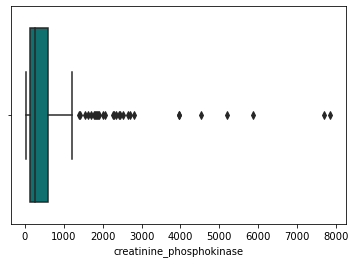

In [6]:
#creating boxplot for creatinine phosphokinase
sns.boxplot(x = data.creatinine_phosphokinase, color = 'teal')
plt.show()

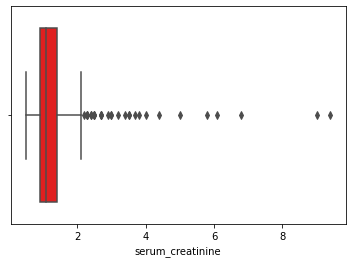

In [7]:
#creating boxplot for serume creatinine
sns.boxplot(x = data.serum_creatinine, color = 'red')
plt.show()

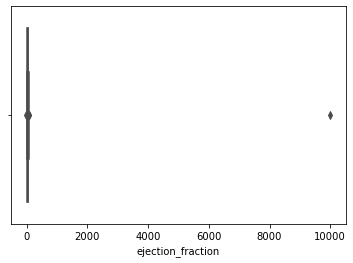

In [8]:
#creating boxplot for creatinine phosphokinase
sns.boxplot(x = data.ejection_fraction, color = 'yellow')
plt.show()

In [9]:
#Find values in ejection fraction that are less than 0 and more than 100%
data.loc[(data['ejection_fraction'] <0) | (data['ejection_fraction'] >100)]

,patient_identifier,age,anemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,current_smoker,room_number,hospital,DEATH_EVENT
34,138,65.0,No,94,NaN,-20,Yes,188000.0,1.0,140,Male,No,929d,AdventHealth,1
200,304,63.0,Yes,1767,NaN,10000,No,73000.0,0.7,137,male,No,257x,ACMH Hospital,0


In [10]:
#dropping noisy data points
data = data.drop(labels=[34,200], axis=0)

*Analysis:*
- Upon further research, patients with serious diseases and illnesses can be seen with extremely high results. Therefore, the data points in the boxplot above are not outliers, as they are possible results in very ill patients. 
- For the ejection fraction percentage, there were 2 noisy data points that were not explainable and therefore were removed from the dataset. 

In [11]:
data.shape

(297, 15)

In [12]:
data['sex'].value_counts()

Male      164
Female     89
male       22
female     15
M           6
F           1
Name: sex, dtype: int64

In [13]:
#converting all sexes to be a uniform str
#for males
data.sex[data.sex == 'Male'] = 'male'
data.sex[data.sex == 'M'] = 'male'
#for females
data.sex[data.sex == 'Female'] = 'female'
data.sex[data.sex == 'F'] = 'female'

In [14]:
#double checking sexes for male and females.
data['sex'].value_counts()

male      192
female    105
Name: sex, dtype: int64

In [15]:
data['sex'].dtypes

dtype('O')

In [16]:
#remove patient identifier
data=data[data.columns[1:len(data.columns)]]

In [17]:
#viewing the categorical columns
cat_list=[]
for col in data.columns:
    if data[col].dtype=='object':
        cat_list.append(col)
cat_list

['anemia',
 'diabetes',
 'high_blood_pressure',
 'sex',
 'current_smoker',
 'room_number',
 'hospital']

In [18]:
#value counts of each categorical variable
for col in cat_list:
    print(data[col].value_counts())

No     169
Yes    128
Name: anemia, dtype: int64
No     71
Yes    49
Name: diabetes, dtype: int64
No     193
Yes    104
Name: high_blood_pressure, dtype: int64
male      192
female    105
Name: sex, dtype: int64
No     201
Yes     96
Name: current_smoker, dtype: int64
386z    2
912v    1
363f    1
493i    1
264e    1
       ..
406l    1
175D    1
116m    1
824X    1
506f    1
Name: room_number, Length: 296, dtype: int64
Brandywine Hospital               15
Fairview Range                    14
ACMH Hospital                     14
Dallas Regional Medical Center    12
Bridgeport Hospital               12
Baptist Medical Center South      11
Brattleboro Memorial Hospital     11
Holy Redeemer                     10
AdventHealth                      10
Aspirus Riverview Hospital         9
Dameron Hospital                   9
Altru Health System                7
Danbury Hospital                   5
Name: hospital, dtype: int64


In [19]:
#dropping room number, as it is not a valuable feature.
#data.columns
data = data.drop(['room_number'], axis=1)

In [20]:
#viewing all null values
data.isnull().sum()

age                          15
anemia                        0
creatinine_phosphokinase      0
diabetes                    177
ejection_fraction             0
high_blood_pressure           0
platelets                    30
serum_creatinine              0
serum_sodium                  0
sex                           0
current_smoker                0
hospital                    158
DEATH_EVENT                   0
dtype: int64

In [21]:
#Applying get_dummies to convert categorical variable into dummy/indicator variables
#data = pd.get_dummies(data)
data = pd.get_dummies(data, dummy_na=True)
data

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,DEATH_EVENT,anemia_No,anemia_Yes,anemia_nan,diabetes_No,diabetes_Yes,diabetes_nan,high_blood_pressure_No,high_blood_pressure_Yes,high_blood_pressure_nan,sex_female,sex_male,sex_nan,current_smoker_No,current_smoker_Yes,current_smoker_nan,hospital_ACMH Hospital,hospital_AdventHealth,hospital_Altru Health System,hospital_Aspirus Riverview Hospital,hospital_Baptist Medical Center South,hospital_Brandywine Hospital,hospital_Brattleboro Memorial Hospital,hospital_Bridgeport Hospital,hospital_Dallas Regional Medical Center,hospital_Dameron Hospital,hospital_Danbury Hospital,hospital_Fairview Range,hospital_Holy Redeemer,hospital_nan
0,75.0,582,20,265000.00,1.9,130,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,55.0,7861,38,263358.03,1.1,136,1,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,65.0,146,20,162000.00,1.3,129,1,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,50.0,111,20,210000.00,1.9,137,1,0,1,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,65.0,160,20,327000.00,2.7,116,1,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,61,38,155000.00,1.1,143,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
295,55.0,1820,38,270000.00,1.2,139,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
296,45.0,2060,60,742000.00,0.8,138,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
297,45.0,2413,38,140000.00,1.4,140,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [22]:
#Removing all of the other columns that are not valuable
index = data.index
for i in data.columns:
    if ('_nan' in i):
        if (data[i].sum() == 0) or (data[i].sum() == len(index)):
            data = data.drop([i],axis=1) 

*Pre-processing changes and decisions:* <br>
1. The data seems to be an imbalanced data set with missing values and a few noisy data points.  The noisy data points from ejection_fraction were removed.  
2. Changing all of the male and females to be spelled the same.  
3. The column 'room_number' and the patient identifier were removed because they are independent and do not provide valuable information in death count. 
4. For the sake of time and simplicity, get_dummies was used to convert the rest of the categorical variables into indicator variables. These categorical variables have null values, but get_dummies will take care of this by creating a column for the null values. For example, 'diabetes_nan' - with this, we will not need to impute values for it later on. 
5. Any variables ending with '_nan' that are all 0s or all 1s have also been removed, as they are not valuable either. 

**Splitting data**

In [23]:
#split the data
X = data.drop(['DEATH_EVENT'],axis=1) #selecting all rows except for death event.
y = data['DEATH_EVENT']

**Bootstrapping** <br>
With the dataset being quite small, I have decided to do some bootstrapping on it. 

In [24]:
#Creating a bootstrap for X_test and y_test
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42)

data_split_test = []
for i in range(0, 100): #bootstrapping, creating 100 different training and testing sets
    S1_test, S1_label = resample(X_test, y_test, random_state=i) #creating different random_states
    data_split_test.append([S1_test, S1_label])

**Data Analysis**

In [25]:
X_train.shape

(207, 31)

In [26]:
X_train.isnull().sum()

age                                         8
creatinine_phosphokinase                    0
ejection_fraction                           0
platelets                                  22
serum_creatinine                            0
serum_sodium                                0
anemia_No                                   0
anemia_Yes                                  0
diabetes_No                                 0
diabetes_Yes                                0
diabetes_nan                                0
high_blood_pressure_No                      0
high_blood_pressure_Yes                     0
sex_female                                  0
sex_male                                    0
current_smoker_No                           0
current_smoker_Yes                          0
hospital_ACMH Hospital                      0
hospital_AdventHealth                       0
hospital_Altru Health System                0
hospital_Aspirus Riverview Hospital         0
hospital_Baptist Medical Center So

**Imputing**

In [27]:
#imputing values for age and platelets
imp_mean = SimpleImputer(missing_values=np.NaN, strategy='mean')

#fit the model with X_train
imp_mean.fit(X_train)

#transform with X_train
X_train=imp_mean.transform(X_train) 

#transform with data subsets 
for i in range(0,100):
    data_split_test[i][0] = imp_mean.transform(data_split_test[i][0])

*Note:* The missing null values have been imputed with the mean for each feature. 

In [28]:
#converting X_train from np.array back to dataframe
X_train = pd.DataFrame(data=X_train, columns=X.columns)

#converting subsets from np.array back to dataframe
for i in range(0,100):
    data_split_test[i][0] = pd.DataFrame(data=data_split_test[i][0], columns=X.columns)

**Standardizing**

In [29]:
#standardization
scaler = StandardScaler()

#fit the model with X_train
scaler.fit(X_train)

#transform the model with X_train and all the bootstrap subsets
X_train = scaler.transform(X_train)

for i in range(0,100):
    data_split_test[i][0] = scaler.transform(data_split_test[i][0])

**Stratified KFold**<br>
Data is imbalanced so we will apply stratified Kfold.

In [30]:
#stratified KFold
skfolds = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

**Logistic Regression**

In [31]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create randomized search with skfold iterations
clf = RandomizedSearchCV(LogisticRegression(solver='liblinear'), hyperparameters, scoring='f1_micro', cv=skfolds, random_state=1)

# Fit random search
best_model = clf.fit(X_train, y_train)

# print best parameter after tuning
print('best parameters: ', best_model.best_params_)
  
# print how our model looks after hyper-parameter tuning
print('best model :', best_model.best_estimator_)

#print best averaged score between all the skfolds
print('best score for training:', best_model.best_score_)

# Predict target vector
#iterate through 100 subsets predict with each data_split_test
lr_score = []
for i in range(0,100):    
    lr_y_pred = best_model.predict(data_split_test[i][0]) 
    score = f1_score(lr_y_pred, data_split_test[i][1], average='micro')
    lr_score.append(score)

best parameters:  {'penalty': 'l1', 'C': 7.742636826811269}
best model : LogisticRegression(C=7.742636826811269, penalty='l1', solver='liblinear')
best score for training: 0.7293844367015099


In [32]:
#taking the average scores of all the bootstrap subsets
lr_model = sum(lr_score)/len(lr_score)
lr_model

0.7193333333333334

**Support Vector Machine**


In [33]:
parameters = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

#randomized search with SVC
svc_clf = RandomizedSearchCV(SVC(), parameters, scoring='f1_micro', cv=skfolds, random_state=1)

#fit model on training data
svc_model = svc_clf.fit(X_train, y_train)

# print best parameter after tuning
print('best parameters: ', svc_model.best_params_)
  
# print how our model looks after hyper-parameter tuning
print('best model :', svc_model.best_estimator_)

#print best averaged score between all the skfolds
print('best score for training:', svc_model.best_score_)

#create list
svm_score = []
for i in range(0,100):    
    svm_pred = svc_model.predict(data_split_test[i][0])
    score = f1_score(svm_pred, data_split_test[i][1], average='micro')
    svm_score.append(score)

best parameters:  {'kernel': 'rbf', 'gamma': 0.001, 'C': 100}
best model : SVC(C=100, gamma=0.001)
best score for training: 0.7292682926829268


In [34]:
#taking the average scores of all the bootstrap subsets
svm_model = (sum(svm_score)/len(svm_score))
svm_model

0.7055555555555556

**RandomForest**

In [35]:
random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [130, 180, 230]}

rf = RandomForestClassifier(random_state = 35)
rf_clf = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='f1_micro', cv=skfolds, random_state=1)

#fit model
rf_model = rf_clf.fit(X_train, y_train)

# print best parameter after tuning
print('best parameters: ', rf_model.best_params_)
  
# print how our model looks after hyper-parameter tuning
print('best model :', rf_model.best_estimator_)

#print best averaged score between all the skfolds
print('best score for training:', rf_model.best_score_)

rf_score = []
for i in range(0,100):
    #print(i)
    rf_y_pred = rf_model.predict(data_split_test[i][0])
    score = f1_score(rf_y_pred, data_split_test[i][1], average='micro')
    rf_score.append(score)

best parameters:  {'n_estimators': 130, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
best model : RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_leaf=2,
                       n_estimators=130, random_state=35)
best score for training: 0.7875725900116144


In [36]:
#taking the average scores of all the bootstrap subsets
randomforest_model = (sum(rf_score)/len(rf_score))
randomforest_model

0.7291111111111112

In [37]:
print(' scores for each model:\n', f'{randomforest_model = } {svm_model = } {lr_model = }')

 scores for each model:
 randomforest_model = 0.7291111111111112 svm_model = 0.7055555555555556 lr_model = 0.7193333333333334


*Model Analysis:*<br>
The data were tested on 3 different models: Logistic regression, SVM, and RandomForestClassifier.  Each of the 100 subsets created from bootstrapping were predicted, scored, and then the average was calculated for an overall score of the model.  According to the caclulated test scores, the best model is random forest classifier with a 72.9% f1 micro average score. Because our dataset was imbalanced, accuracy is not a proper measure since it does not distinguish between numbers of correctly classified examples of different classes, therfore f1-micro average score was selected for the multiclass imbalanced dataset.

With results of >70% f1 in training and testing, I do not suspect that there is overfitting, though it is to note that the dataset still needs a plotted learning curve to evaluate for underfitting and overfitting of the training and testing.  In addition to this, an application of VIF to assess the severity of the multicollinearity in regression analysis is also necessary, but due to the time constraint of this exercise those steps were not applied. 

